In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [86]:
df=pd.read_csv("Global_Pollution_Analysis.csv")

In [87]:
df1=df.interpolate(method='linear',limit_direction='forward')

<ipython-input-87-c808b6af8458>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df1=df.interpolate(method='linear',limit_direction='forward')


In [88]:
from sklearn import preprocessing
numeric_columns = df1 .select_dtypes(include=['float64', 'int64']).columns
features = numeric_columns.drop('Year')

normalized_data = preprocessing.normalize(df1[features])

normalized_df = pd.DataFrame(normalized_data, columns=features, index=df1.index)

df_remaining = df1.drop(columns=features)

df2 = pd.concat([df_remaining, normalized_df], axis=1)
df2

,Country,Year,Air_Pollution_Index,Water_Pollution_Index,Soil_Pollution_Index,Industrial_Waste (in tons),Energy_Recovered (in GWh),CO2_Emissions (in MT),Renewable_Energy (%),Plastic_Waste_Produced (in tons),Energy_Consumption_Per_Capita (in MWh),Population (in millions),GDP_Per_Capita (in USD)
0,Hungary,2005,0.002624,0.001196,0.000500,0.912139,0.001522,0.000051,0.000396,0.356752,0.000121,0.000406,0.201790
1,Singapore,2001,0.001171,0.000815,0.001583,0.760302,0.006728,0.000086,0.000492,0.447507,0.000071,0.001854,0.470771
2,Romania,2016,0.001106,0.001007,0.001470,0.679396,0.005912,0.000600,0.000113,0.227087,0.000159,0.001503,0.697718
3,Cook Islands,2018,0.003574,0.000855,0.001192,0.953398,0.001849,0.000113,0.000242,0.116936,0.000010,0.000863,0.278099
4,Djibouti,2008,0.001872,0.001333,0.001270,0.803111,0.000422,0.000156,0.000355,0.409957,0.000134,0.001949,0.432362
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Latvia,2004,0.002235,0.001519,0.000817,0.955043,0.001567,0.000094,0.000335,0.078437,0.000121,0.001793,0.285880
196,Bangladesh,2002,0.001192,0.001183,0.000626,0.730670,0.000253,0.000452,0.000162,0.361011,0.000148,0.001115,0.579472
197,Korea,2011,0.003928,0.003854,0.000972,0.073945,0.007693,0.001009,0.001006,0.647948,0.000370,0.004802,0.758010
198,Vanuatu,2002,0.003348,0.001604,0.001439,0.970317,0.004313,0.000407,0.000454,0.020376,0.000176,0.000574,0.240904


In [89]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)].index

# Identify outliers in specific columns
outliers_co2 = detect_outliers_iqr(df, 'CO2_Emissions (in MT)')
outliers_waste = detect_outliers_iqr(df, 'Industrial_Waste (in tons)')
all_outliers = set(outliers_co2).union(set(outliers_waste))
print(f"Number of outliers detected: {len(all_outliers)}")

Number of outliers detected: 0


In [90]:
label_encoder_country = LabelEncoder()
label_encoder_year = LabelEncoder()
df2['Country_encoded'] = label_encoder_country.fit_transform(df2['Country'])
df2['Year_encoded'] = label_encoder_year.fit_transform(df2['Year'])

# Drop original categorical columns (optional)
df_processed = df2.drop(['Country', 'Year'], axis=1)

# Show processed dataframe
print(df_processed)

     Air_Pollution_Index  Water_Pollution_Index  Soil_Pollution_Index  \
0               0.002624               0.001196              0.000500   
1               0.001171               0.000815              0.001583   
2               0.001106               0.001007              0.001470   
3               0.003574               0.000855              0.001192   
4               0.001872               0.001333              0.001270   
..                   ...                    ...                   ...   
195             0.002235               0.001519              0.000817   
196             0.001192               0.001183              0.000626   
197             0.003928               0.003854              0.000972   
198             0.003348               0.001604              0.001439   
199             0.002069               0.002419              0.001371   

     Industrial_Waste (in tons)  Energy_Recovered (in GWh)  \
0                      0.912139                   0.001522   

In [91]:
df2['Total_Pollution_Index'] = (
    df2['Air_Pollution_Index'] +
    df2['Water_Pollution_Index'] +
    df2['Soil_Pollution_Index']
)
df2['Avg_Pollution_By_Year'] = df2.groupby(['Year'])['Total_Pollution_Index'].transform('mean')
df2['Pollution_Per_Capita'] = (
    df2['Total_Pollution_Index'] / df2['Population (in millions)']
)
df2

,Country,Year,Air_Pollution_Index,Water_Pollution_Index,Soil_Pollution_Index,Industrial_Waste (in tons),Energy_Recovered (in GWh),CO2_Emissions (in MT),Renewable_Energy (%),Plastic_Waste_Produced (in tons),Energy_Consumption_Per_Capita (in MWh),Population (in millions),GDP_Per_Capita (in USD),Country_encoded,Year_encoded,Total_Pollution_Index,Avg_Pollution_By_Year,Pollution_Per_Capita
0,Hungary,2005,0.002624,0.001196,0.000500,0.912139,0.001522,0.000051,0.000396,0.356752,0.000121,0.000406,0.201790,77,5,0.004319,0.005391,10.632875
1,Singapore,2001,0.001171,0.000815,0.001583,0.760302,0.006728,0.000086,0.000492,0.447507,0.000071,0.001854,0.470771,147,1,0.003570,0.004141,1.925537
2,Romania,2016,0.001106,0.001007,0.001470,0.679396,0.005912,0.000600,0.000113,0.227087,0.000159,0.001503,0.697718,136,16,0.003583,0.006133,2.383466
3,Cook Islands,2018,0.003574,0.000855,0.001192,0.953398,0.001849,0.000113,0.000242,0.116936,0.000010,0.000863,0.278099,38,18,0.005621,0.005281,6.509587
4,Djibouti,2008,0.001872,0.001333,0.001270,0.803111,0.000422,0.000156,0.000355,0.409957,0.000134,0.001949,0.432362,46,8,0.004475,0.005951,2.295947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Latvia,2004,0.002235,0.001519,0.000817,0.955043,0.001567,0.000094,0.000335,0.078437,0.000121,0.001793,0.285880,92,4,0.004571,0.005431,2.548731
196,Bangladesh,2002,0.001192,0.001183,0.000626,0.730670,0.000253,0.000452,0.000162,0.361011,0.000148,0.001115,0.579472,13,2,0.003001,0.005523,2.690230
197,Korea,2011,0.003928,0.003854,0.000972,0.073945,0.007693,0.001009,0.001006,0.647948,0.000370,0.004802,0.758010,88,11,0.008753,0.006107,1.822845
198,Vanuatu,2002,0.003348,0.001604,0.001439,0.970317,0.004313,0.000407,0.000454,0.020376,0.000176,0.000574,0.240904,170,2,0.006391,0.005523,11.138745


In [92]:
def categorize_severity(value):
    if value < 0.004:
        return 'Low'
    elif value < 0.0066:
        return 'Medium'
    else:
        return 'High'


df2['Pollution_Severity'] = df2['Total_Pollution_Index'].apply(categorize_severity)
df2

,Country,Year,Air_Pollution_Index,Water_Pollution_Index,Soil_Pollution_Index,Industrial_Waste (in tons),Energy_Recovered (in GWh),CO2_Emissions (in MT),Renewable_Energy (%),Plastic_Waste_Produced (in tons),Energy_Consumption_Per_Capita (in MWh),Population (in millions),GDP_Per_Capita (in USD),Country_encoded,Year_encoded,Total_Pollution_Index,Avg_Pollution_By_Year,Pollution_Per_Capita,Pollution_Severity
0,Hungary,2005,0.002624,0.001196,0.000500,0.912139,0.001522,0.000051,0.000396,0.356752,0.000121,0.000406,0.201790,77,5,0.004319,0.005391,10.632875,Medium
1,Singapore,2001,0.001171,0.000815,0.001583,0.760302,0.006728,0.000086,0.000492,0.447507,0.000071,0.001854,0.470771,147,1,0.003570,0.004141,1.925537,Low
2,Romania,2016,0.001106,0.001007,0.001470,0.679396,0.005912,0.000600,0.000113,0.227087,0.000159,0.001503,0.697718,136,16,0.003583,0.006133,2.383466,Low
3,Cook Islands,2018,0.003574,0.000855,0.001192,0.953398,0.001849,0.000113,0.000242,0.116936,0.000010,0.000863,0.278099,38,18,0.005621,0.005281,6.509587,Medium
4,Djibouti,2008,0.001872,0.001333,0.001270,0.803111,0.000422,0.000156,0.000355,0.409957,0.000134,0.001949,0.432362,46,8,0.004475,0.005951,2.295947,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Latvia,2004,0.002235,0.001519,0.000817,0.955043,0.001567,0.000094,0.000335,0.078437,0.000121,0.001793,0.285880,92,4,0.004571,0.005431,2.548731,Medium
196,Bangladesh,2002,0.001192,0.001183,0.000626,0.730670,0.000253,0.000452,0.000162,0.361011,0.000148,0.001115,0.579472,13,2,0.003001,0.005523,2.690230,Low
197,Korea,2011,0.003928,0.003854,0.000972,0.073945,0.007693,0.001009,0.001006,0.647948,0.000370,0.004802,0.758010,88,11,0.008753,0.006107,1.822845,High
198,Vanuatu,2002,0.003348,0.001604,0.001439,0.970317,0.004313,0.000407,0.000454,0.020376,0.000176,0.000574,0.240904,170,2,0.006391,0.005523,11.138745,Medium


Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         8
         Low       0.00      0.00      0.00        13
      Medium       0.47      1.00      0.64        19

    accuracy                           0.47        40
   macro avg       0.16      0.33      0.21        40
weighted avg       0.23      0.47      0.31        40

[[ 0  0  8]
 [ 0  0 13]
 [ 0  0 19]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

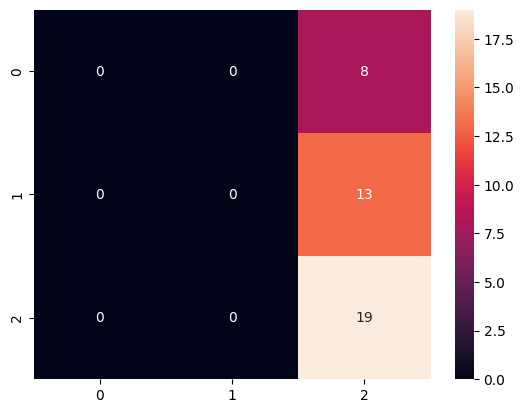

In [130]:
numeric_columns = df2.select_dtypes(include=['float64', 'int64']).columns
features = numeric_columns.drop(['Year','Country_encoded','Year_encoded'])
X = df2[features]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df2['Pollution_Severity'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = MultinomialNB()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
cf=confusion_matrix(y_test,y_pred)
print(cf)
import seaborn as sns
sns.heatmap(cf,annot=True)

In [109]:

X = df2[['Air_Pollution_Index','Water_Pollution_Index','Soil_Pollution_Index']]
y = df2['Pollution_Severity']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
accuracy = []

k_range = range(1, 10)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    accuracy.append(scores.mean())
    print(f"Average CV accuracy for k = {k}: {scores.mean():.4f}")

# Find optimal k
optimal_k = k_range[np.argmax(accuracy)]
print(f" Optimal number of neighbors (K): {optimal_k}")

Average CV accuracy for k = 1: 0.9100
Average CV accuracy for k = 2: 0.8850
Average CV accuracy for k = 3: 0.9250
Average CV accuracy for k = 4: 0.9250
Average CV accuracy for k = 5: 0.9150
Average CV accuracy for k = 6: 0.9250
Average CV accuracy for k = 7: 0.8900
Average CV accuracy for k = 8: 0.9300
Average CV accuracy for k = 9: 0.9100
 Optimal number of neighbors (K): 8


In [110]:
Knn=KNeighborsClassifier(n_neighbors=optimal_k)
Knn.fit(x_train,y_train)
y_pred=Knn.predict(x_test)
print(y_pred)

['Low' 'Medium' 'Low' 'High' 'Medium' 'Medium' 'Low' 'Medium' 'Low'
 'Medium' 'Medium' 'High' 'Medium' 'Low' 'Low' 'High' 'Medium' 'Medium'
 'Low' 'High' 'High' 'Low' 'High' 'Medium' 'Medium' 'Medium' 'Medium'
 'Low' 'Medium' 'Medium' 'High' 'Low' 'Medium' 'Low' 'Medium' 'Low'
 'Medium' 'Medium' 'Medium' 'Low']


              precision    recall  f1-score   support

        High       1.00      0.88      0.93         8
         Low       0.92      0.92      0.92        13
      Medium       0.90      0.95      0.92        19

    accuracy                           0.93        40
   macro avg       0.94      0.92      0.93        40
weighted avg       0.93      0.93      0.93        40

[[ 7  0  1]
 [ 0 12  1]
 [ 0  1 18]]


<Axes: >

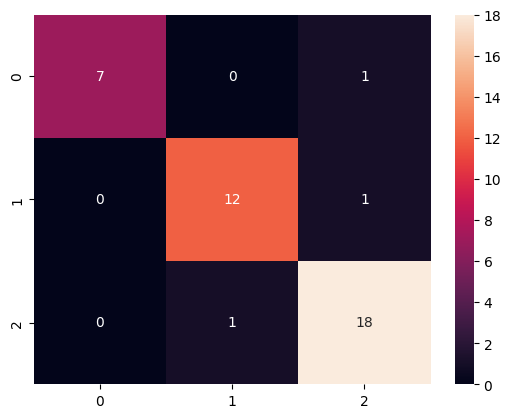

In [111]:
print(classification_report(y_test, y_pred))
cf=confusion_matrix(y_test,y_pred)
print(cf)
import seaborn as sns
sns.heatmap(cf,annot=True)

Best Parameters: {'max_depth': 2, 'min_samples_split': 2}

Classification Report:
               precision    recall  f1-score   support

        High       0.87      1.00      0.93        13
         Low       1.00      1.00      1.00        18
      Medium       1.00      0.93      0.96        29

    accuracy                           0.97        60
   macro avg       0.96      0.98      0.96        60
weighted avg       0.97      0.97      0.97        60

[[13  0  0]
 [ 0 18  0]
 [ 2  0 27]]


<Axes: >

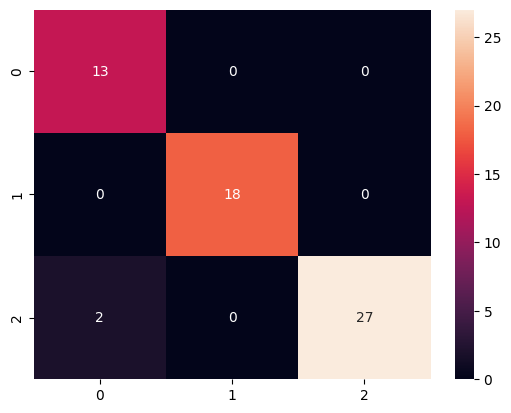

In [128]:
numeric_columns = df2.select_dtypes(include=['float64', 'int64']).columns
features = numeric_columns.drop(['Year','Country_encoded','Year_encoded'])
X = df2[features]

y =df2['Pollution_Severity']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'max_depth':  list(range(1, 20)),
    'min_samples_split': list(range(2, 20))
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_


y_pred = best_tree.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
cf=confusion_matrix(y_test,y_pred)
print(cf)
import seaborn as sns
sns.heatmap(cf,annot=True)

# Confusion Matrix Insights
* Decision Tree perfectly classified all samples with 97% accuracy
* KNN is also perfectly classified with 93% accuracy

* MultinomialNB struggled — likely due to its assumption of feature independence and discrete counts, which doesn’t fit continuous pollution data well.

# Key Findings:
* Countries with high air, water, and soil pollution indices consistently fall into the High Severity category.

* Features like CO₂ emissions, industrial waste, and energy consumption per capita heavily influence severity classification.

* Energy Recovery tends to be inversely related to total pollution — highly polluted countries often have less efficient energy recovery systems.


# Recommended Policies:
### 1. Target High Pollution Areas:

* Focus environmental regulation on countries repeatedly predicted as High severity.

* Invest in air/water purification infrastructure.

### 2. Boost Energy Recovery:
* Encourage industries to implement waste-to-energy technologies.

* Provide subsidies or tax incentives for adopting sustainable practices.

### 3. Promote Data-Driven Environmental Monitoring:

* Use models like this for real-time classification of pollution severity by region.

* Empower governments with dashboards to track improvements.